<a href="https://colab.research.google.com/github/huerd/GPA659-E2020/blob/howard%2Fcontinue/_project/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Resources*

### Visualisations
*   Image Files to Numpy Array : https://www.kaggle.com/lgmoneda/from-image-files-to-numpy-arrays
*   MobileNetV2 Dogs/Cats implementation : https://www.kaggle.com/abdallahhassan/dogs-cats-mobilenetv2-transfere-learning









# Runtime Setup : Authorization w/ Kaggle database and download

1.   Set your Kaggle API .JSON file to this runtime
2.   Downloads and extract dogs-vs-cats.zip into two folders
3.   Installs/replaces other programs



In [2]:
# updates kaggle version
!pip install pillow==7.0.0 
!pip install --upgrade --force-reinstall --no-deps kaggle

# fix https://github.com/keras-team/keras-preprocessing/issues/116 for datagen
!pip uninstall -y keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

from google.colab import files
import zipfile

# select your Kaggle API kaggle.json
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# make sure to create a kaggle account, get it verified (phone number and all)
# then go accept terms here : https://www.kaggle.com/c/dogs-vs-cats

# zip should be downloaded to /content/
!kaggle competitions download -c dogs-vs-cats
unzipMaster = zipfile.ZipFile("dogs-vs-cats.zip", 'r')
unzipMaster.extractall()
unzipMaster.close()

# don't expand the folders unless you want colab to crash on you
# file format is 1.jpg, 2.jpg, etc
unzipTest1 = zipfile.ZipFile("test1.zip", 'r')
unzipTest1.extractall()
unzipTest1.close()

# file format is cat.0.jpg, dog.2.jpg, etc
unzipTrain1 = zipfile.ZipFile("train.zip", 'r')
unzipTrain1.extractall()
unzipTrain1.close()

     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=6ca0b23fe0cacc6e6a82cb52292b949a22fc334447335dbf32343b619499b794
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-uth_sc_a
  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-uth_sc_a
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-cp36-none-any.whl size=42983 sha256=cace9bbecc7737047af3f807e2f9d5163ab46f53895e2882a172bb1673d42a63
  Stored in directory: /tmp/pip-ephem-wheel-cache-ud7__et_/wheels

KeyboardInterrupt: ignored

# Dev Environment Setup

In [2]:
from __future__ import print_function

# uncomment below to use version 1.x
#%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from scipy import ndimage
import matplotlib.pyplot as plt
import pandas
import numpy
import os, sys
import IPython.display
import PIL.Image
import random

Using TensorFlow backend.


## Constants

In [1]:
IMAGE_WIDTH = 128
IMAGE_LENGTH = 128
IMAGE_SIZE = [IMAGE_WIDTH, IMAGE_LENGTH]
IMAGE_NUMCHANNELS = 3

TRAININGDATASPLIT_RATIO = 0.9
BATCH_SIZE = 16
SEED = 4

QUICK_TRAIN = True
EPOCH_QUICK = 3
EPOCH_NORMAL = 50


# Data Preperation

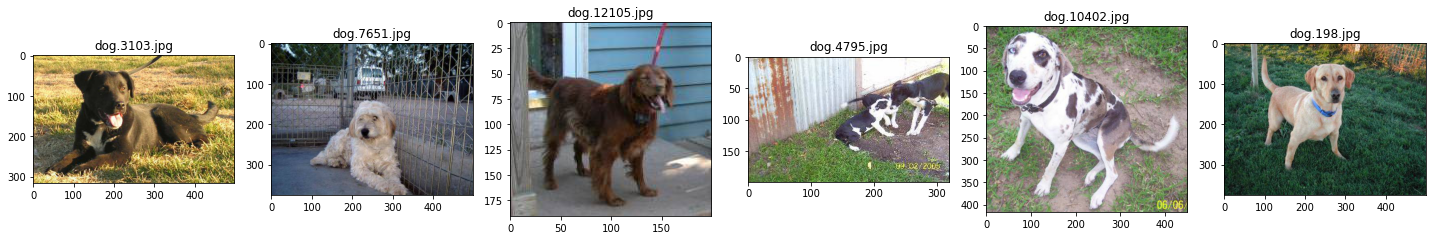

Total Counts from Labeled Data


cat    12500
dog    12500
Name: petType, dtype: int64

In [4]:
trainingData_dir = "train/"
testingData_dir = "test1/"

# load data
labeledDataset = os.listdir(trainingData_dir)
testingDataset = os.listdir(testingData_dir)

results = []

# loop through our labeledDataset, one file at a time
for eachImage in labeledDataset:
  # recall that our labeledDataset file format is [animal].[num].jpg
  petType = eachImage.split('.')[0]
  if petType == 'cat':
    results.append("cat")
  else:
    results.append("dog")

# df_labeled is where all our labeled data is stored in a DataFrame
df_labeled = pandas.DataFrame({
    'imageName': labeledDataset,
    'petType': results
})

## Visualizations
# create figure size
plt.figure(figsize=(20, 12))
for i in range(0, 6):
    plt.subplot(1, 6, i+1)
    imageName = random.choice(labeledDataset)
    image = load_img(trainingData_dir + imageName)
    plt.title(imageName)
    plt.imshow(image)
plt.tight_layout()
plt.show()

print("Total Counts from Labeled Data")
df_labeled['petType'].value_counts()

## Training Data allocation

We ratio the labeled training data into two sets
* Data used to train our model (training data)
* Data used to validate our model (validation data)

In [5]:
from sklearn.model_selection import train_test_split

# split your labeled dataset into training and validation sets based on a ratio
# if train_size is 0.3, then training is 70% of the dataset
df_training, df_validation = train_test_split(df_labeled, train_size = TRAININGDATASPLIT_RATIO)

# pandas.DataFrame.shape is a tuple
# https://www.programiz.com/python-programming/methods/tuple
total_dfTraining = df_training.shape[0]
total_dfValidation = df_validation.shape[0]


print("Labeled Data Allocation")
fmt = '{:<4} {:<2} {:<15} '
print(fmt.format("Train :", "", total_dfTraining))
print(fmt.format("Valid :", "", total_dfValidation))

# ref https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main1.ipynb

Labeled Data Allocation
Train :    22500           
Valid :    2500            


## Preprocessing - Data Augmentation

Data Augmentation is used to apply various transforms to existing labeled
data to increase data diversity, without having to gather new data.

* Keras' [ImageDataPrerocessing](https://keras.io/api/preprocessing/image/) API
*   https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
*   https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb

*   [In-depth on Data Augmentation](https://medium.com/mlait/image-data-augmentation-image-processing-in-tensorflow-part-2-b77237256df0)

*  [Image Classification using data generators](https://mc.ai/tutorial-image-classification-with-keras-flow_from_directory-and-generators/)




Training Data Augmentation

Found 22500 validated image filenames belonging to 2 classes.
Visualized Example of Generator.


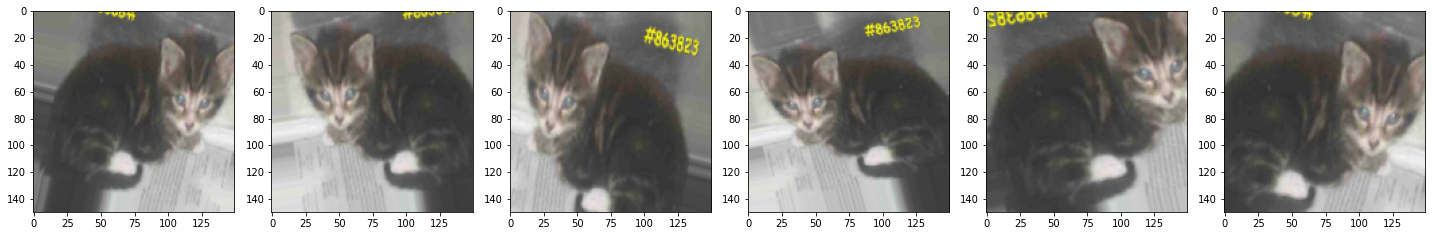

In [6]:
# playing around here I guess
dg_training = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip= True,
    fill_mode = 'nearest',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

# Returns 
# A DataFrameIterator yielding tuples of (x, y) where x is a numpy array 
# containing a batch of images with shape (batch_size, *target_size, channels) 
# and y is a numpy array of corresponding labels.

train_generator = dg_training.flow_from_dataframe(
    df_training, 
    directory = trainingData_dir, 
    x_col = 'imageName',
    y_col = 'petType',
    # class_mode = 'binary',
    class_mode = 'categorical',
    target_size = (IMAGE_WIDTH, IMAGE_LENGTH),
    batch_size = BATCH_SIZE,
    seed = SEED
)

print("Visualized Example of Generator.")
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 6, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# TODO have it return random images ?
augmented_images = [train_generator[0][0][0] for i in range(6)]
plotImages(augmented_images)

Validation Data Augmentation

In [7]:
# same stuff but for validation data
# playing around here I guess
dg_validation = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip= True,
    fill_mode = 'nearest',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

# Returns 
# A DataFrameIterator yielding tuples of (x, y) where x is a numpy array 
# containing a batch of images with shape (batch_size, *target_size, channels) 
# and y is a numpy array of corresponding labels.

valid_generator = dg_validation.flow_from_dataframe(
    df_validation, 
    directory = trainingData_dir, 
    x_col = 'imageName',
    y_col = 'petType',
    # class_mode = 'binary',
    class_mode = 'categorical',
    target_size = (IMAGE_WIDTH, IMAGE_LENGTH),
    batch_size = BATCH_SIZE,
    seed = SEED
)

# print("Visualized Example of Generator.")
# def plotImages(images_arr):
#     fig, axes = plt.subplots(1, 6, figsize=(20,20))
#     axes = axes.flatten()
#     for img, ax in zip( images_arr, axes):
#         ax.imshow(img)
#     plt.tight_layout()
#     plt.show()

# # TODO have it return random images
# augmented_images = [valid_generator[0][0][0] for i in range(6)]
# plotImages(augmented_images)

Found 2500 validated image filenames belonging to 2 classes.


## Test Data (TODO)

# Model Architecture


*   [MobileNet from scratch](https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main2.ipynb)

In [8]:
# mobile = keras.applications.mobilenet.MobileNet()

# TODO : THIS IS JUST A COPY PASTE from the link above. Might have to adjust/change

def mobilenet(input_shape, n_classes):
  
  # TODO modify this to include pointwise ?
  # maybe use this ? https://keras.io/api/layers/convolution_layers/separable_convolution2d/
  def mobilenet_block(x, f, s=1):
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(f, 1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
    
    
  input = Input(input_shape)

  x = Conv2D(32, 3, strides=2, padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model



We want to [adjust learning rate](https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/) when accuracy reaches certain thresholds.

By using [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) algoritm, it estimates the error gradient for the current training model and updates the weights using backpropagation.

API CALLS

* Keras [SGD](https://keras.io/api/optimizers/sgd/)
* [EarlyStopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/) : Used to reduce [overfitting](https://en.wikipedia.org/wiki/Overfitting) the training dataset and improve generalization




In [9]:
# Overfitting setup
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

# learning rate change after accuracy stalls
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

# TODO : I think we might need to actually use an optimizer
#  ref :  

## Summary

In [10]:
input_shape=(IMAGE_WIDTH, IMAGE_LENGTH, IMAGE_NUMCHANNELS);
n_classes = 2;
model = mobilenet(input_shape, n_classes);
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 75, 75, 32)        0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 75, 75, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 75, 75, 32)        0   

## Visualizations

*   Architecture Visualization : https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main4.ipynb

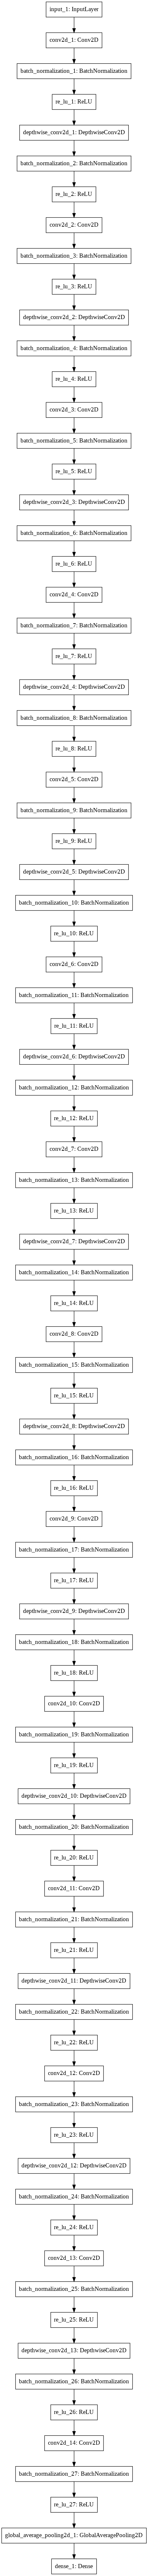

In [11]:
# TODO Make this better

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

plot_model(model,rankdir='TB')

# SVG(model_to_dot(model).create(prog='dot', format='svg'))
# def svg_to_fixed_width_html_image(svg, width="100%"):
#     text = _html_template.format(width, base64.b64encode(svg))
#     return HTML(text)

# svg_to_fixed_width_html_image(output)

# Training Phase

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

epochs = EPOCH_QUICK if QUICK_TRAIN else EPOCH_NORMAL

# todo: depreciated and should change to Model.fit when we have time
history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = valid_generator,
    validation_steps =  total_dfValidation // BATCH_SIZE,
    steps_per_epoch = total_dfValidation // BATCH_SIZE,
    callbacks = callbacks
)

Epoch 1/3
156/156 [==============================] - 378s 2s/step - loss: 0.8183 - acc: 0.5405 - val_loss: 0.7538 - val_acc: 0.5088
Epoch 2/3
156/156 [==============================] - 370s 2s/step - loss: 0.7080 - acc: 0.5950 - val_loss: 0.9545 - val_acc: 0.5097
Epoch 3/3
156/156 [==============================] - 373s 2s/step - loss: 0.6939 - acc: 0.5869 - val_loss: 0.7034 - val_acc: 0.5076


## Feature extraction

* [Gradient Ascent](https://stackoverflow.com/questions/22594063/what-is-the-difference-between-gradient-descent-and-gradient-ascent)


Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Count of all_imgs = 31
i * n + j :0 n: 31
i * n + j :1 n: 31
i * n + j :2 n: 31
i * n + j :3 n: 31
i * n + j :4 n: 31
i * n + j :5 n: 31
i * n + j :6 n: 31
i * n + j :7 n: 31
i * n + j :8 n: 31
i * n + j :9 n: 31
i * n + j :10 n: 31
i * n + j :11 n: 31
i * n + j :12 n: 31
i * n + j :13 n: 31
i * n + j :14 n: 31
i * n + j :15 n: 31
i * n + j :16 n: 31
i * n 

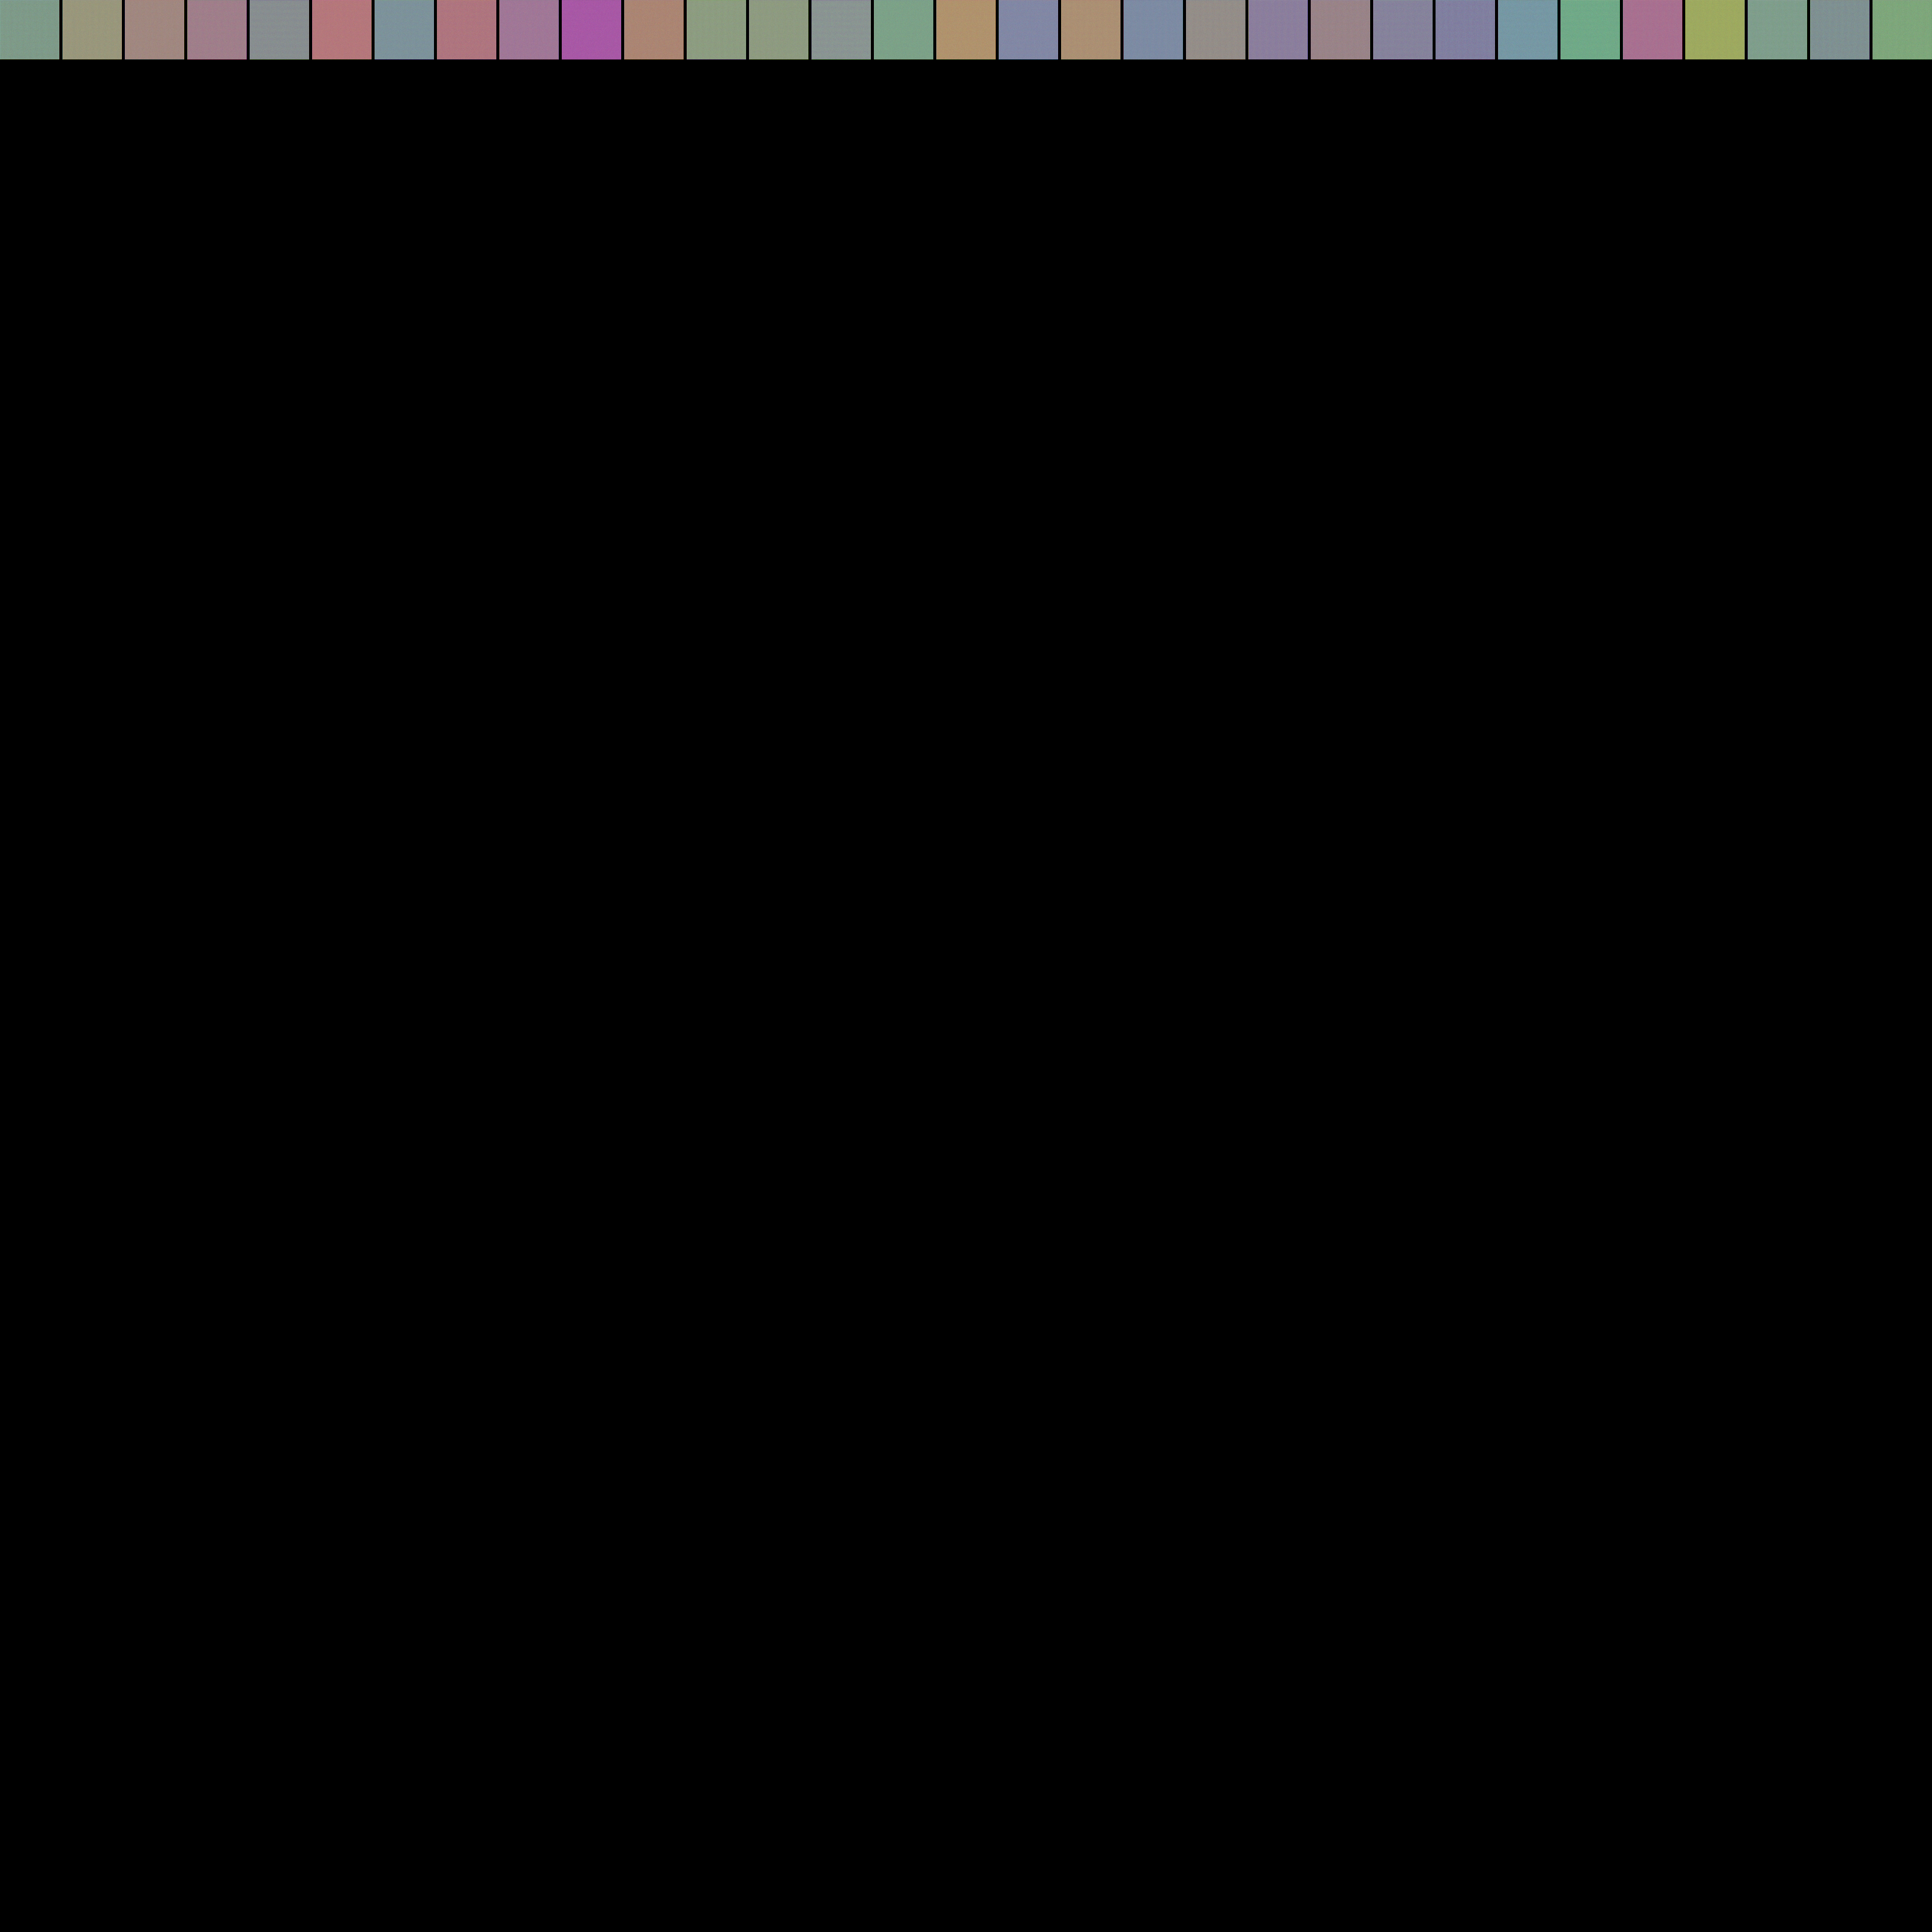

In [44]:
# ref : https://keras.io/examples/vision/visualizing_what_convnets_learn/

layer_name = "conv2d_1"

#  Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = Model(inputs=model.inputs, outputs=layer.output)

# setup gradient ascent process
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

# setup end to end filter visualization loop

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, IMAGE_WIDTH, IMAGE_LENGTH, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = numpy.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = numpy.clip(img, 0, 255).astype("uint8")
    return img

from IPython.display import Image, display
from keras import preprocessing

# loss, img = visualize_filter(0)
# preprocessing.image.save_img("0.png", img)

# display(Image("0.png"))

# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer


all_imgs = []

# TODO : it errors out after layer 32. To look into. Default = 64
# for filter_index in range(64):
for filter_index in range(31):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

print("Count of all_imgs = "+ str(len(all_imgs)))

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = IMAGE_WIDTH - 25 * 2
cropped_height = IMAGE_LENGTH - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = numpy.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        if ((i*n+j) < n):
          print("i * n + j :" + str(i*n+j) + " n: " + str(n))
          img = all_imgs[i * n + j]
          stitched_filters[
              (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
              (cropped_height + margin) * j : (cropped_height + margin) * j
              + cropped_height,
              :,
          ] = img

preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))



# Model Accuracy and Loss graphs

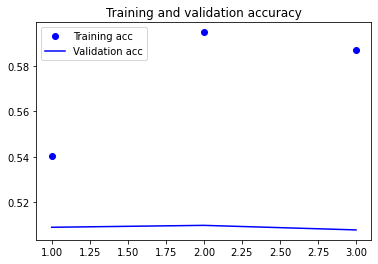

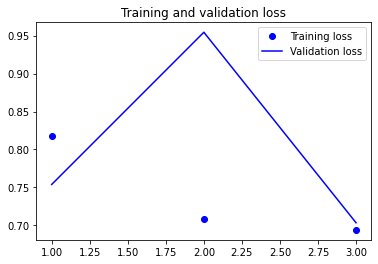

In [13]:
## TODO 

# ref  : https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main2.ipynb

# this is outdated. revert to model.evaluate if possible
# loss, accuracy = model.evaluate_generator(valid_generator, 
#                                           total_dfValidation // BATCH_SIZE, 
#                                           workers=12, 
#                                           use_multiprocessing = True)
# print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))



# def plot_model_history(model_history, accuracy='acc', val_accuracy='val_acc'):
#     fig, axs = plt.subplots(1,2,figsize=(20,20))
#     axs[0].plot(range(1,len(model_history.history[accuracy])+1),model_history.history[accuracy])
#     axs[0].plot(range(1,len(model_history.history[val_accuracy])+1),model_history.history[val_accuracy])
#     axs[0].set_title('Model Accuracy')
#     axs[0].set_ylabel('Accuracy')
#     axs[0].set_xlabel('Epoch')
#     axs[0].set_xticks(numpy.arange(1,len(model_history.history[accuracy])+1),len(model_history.history[accuracy])/10)
#     axs[0].legend(['train', 'val'], loc='best')
#     axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
#     axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
#     axs[1].set_title('Model Loss')
#     axs[1].set_ylabel('Loss')
#     axs[1].set_xlabel('Epoch')
#     axs[1].set_xticks(numpy.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
#     axs[1].legend(['train', 'val'], loc='best')
#     plt.show()
    
# plot_model_history(history)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



# Layer Visualizations

We want to visualize the model's trained filters

* [Official Keras : Visualizing what convnets learn](https://keras.io/examples/vision/visualizing_what_convnets_learn/)
* [How convolutional neural networks see the world](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
* [Kernel Visualizations](https://github.com/raghakot/keras-vis)
* [Tools to design/visualize NN architecture](https://github.com/ashishpatel26/Tools-to-Design-or-Visualize-Architecture-of-Neural-Network)

TypeError: ignored

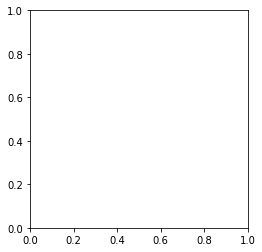

In [14]:
# TODO

import cv2
# imageName = random.choice(testingDataset)
# testImage = load_img(testingData_dir + imageName)
# testImage = numpy.reshape(testImage, (150, 150))

testImage = train_generator[0][0][0] 

# testImage = cv2.imread(testingData_dir + imageName)
# plt.imshow(testImage)
# use the np.resize function to solve that. I apologise for the late response. But use np.resize(img, (-1, <image shape>)
# testImage = cv2.resize(testImage, (150,150))

# here we get rid of that added dimension and plot the image
def visualize_cat(model, test):
    # Keras expects batches of images, so we have to add a dimension to trick it into being nice
    test_batch = numpy.expand_dims(test,axis=0)
    conv_test = model.predict(test_batch)
    conv_test = numpy.squeeze(conv_test, axis=0)
    plt.imshow(conv_test)

test_batch = numpy.expand_dims(testImage,axis=0)
conv_test = model.predict(test_batch)

visualize_cat(model, testImage)

# Confusion Matrix

A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. 